In [1]:
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from pycontractions import Contractions

%matplotlib inline

In [ ]:
cont = Contractions(api_key="glove-twitter-100")
cont.load_models()

In [120]:
raw = pd.read_csv('data.csv')
raw.describe()

,upvotes
count,186277.000000
mean,30.910424
std,298.558384
min,-482.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,32442.000000


In [239]:
raw.comment_body.isna().value_counts()

False    186277
Name: comment_body, dtype: int64

# Cleaning the text data

- Remove numbers, symbols and punctuations (except for comma, which will be removed later)
- Replace URLs with URL token.
- Expand contractions
- Remove commas, tokenize, get stem (root) words and lemmatize the tokens.

In [139]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove("not")
stop_words.remove("no")

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

def spaceURLs(df, column):
    '''This method is used to enforce proper spacing
    Ex: In the data, you may have '[the image](https://image.xyz)';
    this method creates space between alt text ("the image") and the URL.'''
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('\[|\]', ' ', regex=True)
    return data

def removeURL(df, column):
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('\(http\S+', 'URL', regex=True)
    return data

def removeSymbols(df, column):
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('/r/', '', regex=True)
    data.loc[:, column] = data[column].str.replace('[^\.\'A-Za-z0-9]+', ' ', regex=True)
    return data

def removeNumbers(df, column):
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('\S*\d\S*', '', regex=True)
    return data

def processContractions(df, column):
    data = df.copy()
    data["hasContractions"] = data[column].str.contains("'")
    data[column] = data.swifter.apply(lambda row: expandContractions(row["comment_body"]) if row["hasContractions"] 
                              else row["comment_body"], axis=1)
    data.drop(["hasContractions"], axis=1, inplace=True)
    return data

def expandContractions(text):
    return ''.join(list(cont.expand_texts([text], precise=True)))

def processWords(df, column):
    data = df.copy()
    data.loc[:, column] = data[column].str.replace('\.', ' ', regex=True)
    data[column] = data[column].swifter.apply(lambda x: Lemmatize(x))
    return data

def Lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [x.lower() for x in tokens if x.lower() not in stop_words]
    #tokens = [stemmer.stem(x) for x in tokens]
    return ' '.join([lemmatizer.lemmatize(x,pos="v") for x in tokens])

In [140]:
data = spaceURLs(raw, 'comment_body')
data = removeURL(data, 'comment_body')
data = removeNumbers(data, 'comment_body')
data = removeSymbols(data, 'comment_body')

Processing contractions will take some time.

In [141]:
data = processContractions(data, 'comment_body')
data.to_csv("data_contractions_expanded.csv")

In [184]:
data = processWords(data, "comment_body")
data.to_csv("data_preprocessed.csv", index=False)

Based on the summary statistics, we define four categories for upvotes, where x is the upvote count:

- x < 0 : Poor
- x >= 1 and x <= 3: Normal
- x >= 4 and x <=9: Good
- x >= 10: Best

For better performance, all comments with a length > 512 are removed. As shown below, the effect is minimal (removal of ~7k comments, most of which is in normal category).

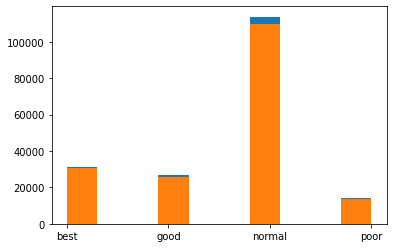

In [4]:
labels = ['poor', 'normal', 'good', 'best']
data["label"] = pd.cut(data["upvotes"], bins=[-np.inf, 0., 3, 9, np.inf], labels=labels)
plt.hist(data["label"].values.tolist())
data = data.loc[data['comment_body'].apply(lambda x: len(x) <= 512), :]
plt.hist(data["label"].values.tolist())
plt.show()

In [21]:
data.describe()

,upvotes
count,186277.000000
mean,30.910424
std,298.558384
min,-482.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,32442.000000


# Further processing

- Dropping empty comments (because it was just emotes, URLs etc that were removed by previous steps)
- Enforcing character limit (better performance)
- Binning the data
- Converting categorical features into ordinal values between 0-3

In [37]:
data = pd.read_csv("data_preprocessed.csv")

In [38]:
def removeCommentsOverLimit(df, charlimit):
    data = df.copy()
    data = data.loc[data['comment_body'].apply(lambda x: len(x) <= charlimit), :]
    return data

def createBins(df, labels):
    data = df.copy()
    data["upvotes"] = pd.cut(data["upvotes"], bins=[-np.inf, 0., 3, 9, np.inf], labels=labels)
    return data

def renameColumns(df):
    return df.rename(columns={"comment_body": "text", "upvotes": "label"})

In [41]:
def prepare(df):
    data = df.copy()
    data = data.dropna()
    labels = ['poor', 'normal', 'good', 'best']
    flairlabels = ['__label__'+x for x in labels]
    data = removeCommentsOverLimit(data, 512)
    data = createBins(data, flairlabels)
    data = renameColumns(data)
    return data

In [42]:
finalData = prepare(data)

In [43]:
finalData.label.value_counts()

__label__normal    111639
__label__best       30920
__label__good       26278
__label__poor       14049
Name: label, dtype: int64

# Save

Split the data into test/train/validation sets and save it in appropriate folder.

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

def saveData(data):
    splits = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for trainIndex, tempIndex in splits.split(data, data.label):
        pass
    trainSet = data.iloc[trainIndex, :]
    tempSet = data.iloc[tempIndex, :]
    splits = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    for testIndex, valIndex in splits.split(tempSet, tempSet.label):
        pass
    testSet = tempSet.iloc[testIndex, :]
    valSet = tempSet.iloc[valIndex, :]
    trainSet.to_csv("flairdata/train.csv", index=False)
    testSet.to_csv("flairdata/test.csv", index=False)
    valSet.to_csv("flairdata/val.csv", index=False)

In [254]:
def savedata(data):
    data = shuffle(data, random_state=42).reset_index(drop=True)
    traintestSplitIndex = int(0.8*len(data))
    trainSet = data[:traintestSplitIndex]
    trainValSplitIndex = int(0.9*len(data))
    testSet = data[traintestSplitIndex:trainValSplitIndex]
    valSet = data[trainValSplitIndex:]
    trainSet.to_csv("flairdata/train.csv", index=False)
    testSet.to_csv("flairdata/test.csv", index=False)
    valSet.to_csv("flairdata/val.csv", index=False)

In [45]:
saveData(finalData)